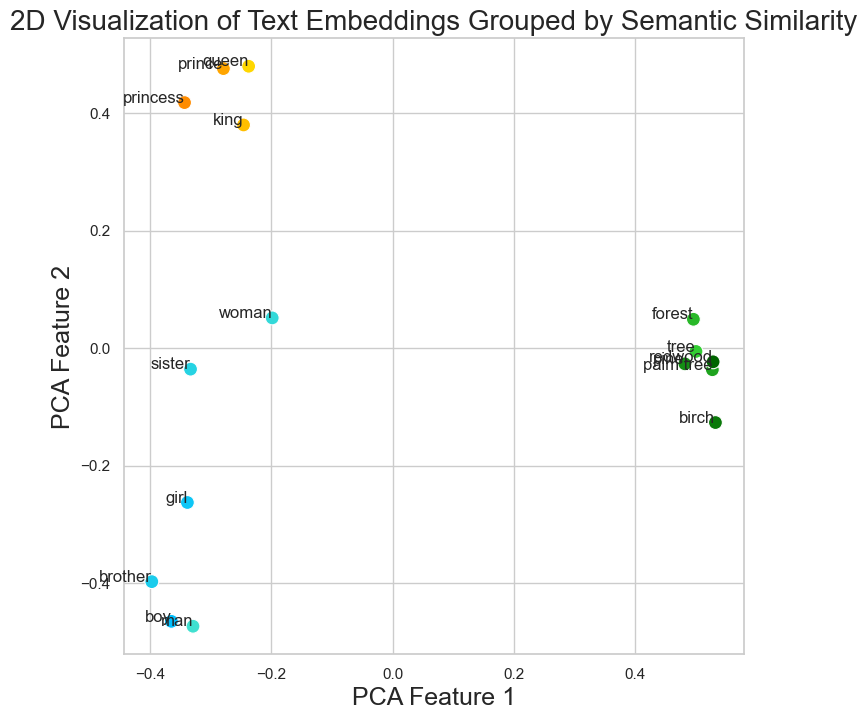

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

# List of texts to embed
texts = ["man", "woman", "queen", "king", "tree", "forest", "palm tree", "pine", "sister", "brother", "prince", "princess", "girl", "boy", "birch", "redwood"]

# Creating synthetic embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts)

# Using PCA for dimensionality reduction
pca = PCA(n_components=2)
embeddings_2d_pca = pca.fit_transform(embeddings)

# Group texts by semantic similarity
groups = {
    'royalty': ["queen", "king", "prince", "princess"],
    'gender': ["man", "woman", "sister", "brother", "girl", "boy"],
    'trees': ["tree", "forest", "palm tree", "pine", "birch", "redwood"]
}

# Create a gradient color palette for each group
color_maps = {
    'royalty': LinearSegmentedColormap.from_list('royalty', ['gold', 'darkorange']),
    'gender': LinearSegmentedColormap.from_list('gender', ['turquoise', 'deepskyblue']),
    'trees': LinearSegmentedColormap.from_list('trees', ['limegreen', 'darkgreen'])
}

# Prepare colors for each point using a gradient within each group
num_items = {group: len(members) for group, members in groups.items()}
point_colors = []
for text in texts:
    for group, members in groups.items():
        if text in members:
            index = members.index(text)
            color_map = color_maps[group]
            color = color_map(index / (num_items[group] - 1))
            point_colors.append(color)

# Plotting
plt.figure(figsize=(8, 8))
scatter = sns.scatterplot(x=embeddings_2d_pca[:, 0], y=embeddings_2d_pca[:, 1], s=100, hue=point_colors, palette=point_colors, legend=None)

# Annotating the plot
for i, text in enumerate(texts):
    plt.text(embeddings_2d_pca[i, 0], embeddings_2d_pca[i, 1], text, fontsize=12, ha='right')

# Title and labels
plt.title("2D Visualization of Text Embeddings Grouped by Semantic Similarity", fontsize=20)
plt.xlabel("PCA Feature 1", fontsize=18)
plt.ylabel("PCA Feature 2", fontsize=18)

# Display the plot
plt.show()


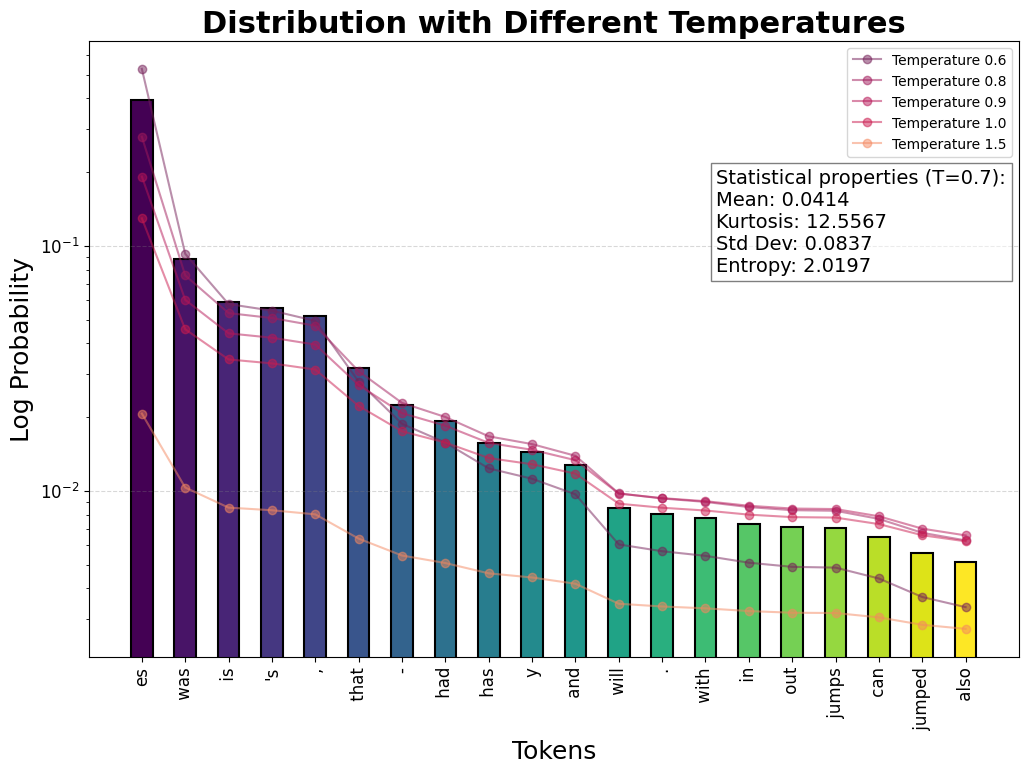

In [28]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kurtosis, entropy
import seaborn as sns

# Load pre-trained model and tokenizer from Hugging Face
model_name = "openai-community/gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()

# Function to get the probability distribution of the next token
def get_next_token_distribution(text, temperature=1.0):
    inputs = tokenizer(text, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits[0, -1, :]
    probs = torch.softmax(logits / temperature, dim=-1).cpu().numpy()
    return probs

# Function to plot the distribution with additional statistics
def plot_distribution(probs, title, top_n=20, temperature=1.0, cmap=None, line_cmap=None):
    top_indices = np.argsort(probs)[-top_n:][::-1]
    top_probs = probs[top_indices]
    top_tokens = [tokenizer.decode([i]) for i in top_indices]
    
    mean = np.mean(top_probs)
    kurt = kurtosis(top_probs)
    std_dev = np.std(top_probs)
    ent = entropy(top_probs)
    
    if temperature == 0.7:
        colors = cmap(np.linspace(0, 1, top_n))
        plt.bar(top_tokens, top_probs, width=0.5, color=colors, edgecolor='black', linewidth=1.5, alpha=1)
        # Add the statistical values to the plot
        stats_text = (
                    f'Statistical properties (T=0.7):\n'
                    f'Mean: {mean:.4f}\n'
                      f'Kurtosis: {kurt:.4f}\n'
                      f'Std Dev: {std_dev:.4f}\n'
                      f'Entropy: {ent:.4f}')
        plt.text(top_n - 6.75, max(top_probs) * 0.2, stats_text, fontsize=14, color='black',
                 bbox=dict(facecolor='white', alpha=0.5))
    else:
        color = line_cmap(temperature / 2)  # Normalize temperature for color mapping
        plt.plot(top_tokens, top_probs, marker='o', color=color, label=f'Temperature {temperature}', alpha=0.5)
    
    plt.title(title, fontsize=22, fontweight='bold', color='black')
    plt.xlabel('Tokens', fontsize=18, color='black')
    plt.ylabel('Log Probability', fontsize=18, color='black')
    plt.xticks(fontsize=12, color='black', rotation=90)
    plt.yticks(fontsize=12, color='black')
    plt.yscale('log')
    plt.grid(axis='y', linestyle='--', alpha=0.3, color='grey')

# Example usage
text = "The quick brown fox"
temperatures = [0.6,0.8,0.9, 1.0, 1.5,0.7]

plt.figure(figsize=(12, 8), facecolor='white')

viridis_cmap = plt.get_cmap('viridis')
rocket_cmap = sns.color_palette("rocket", as_cmap=True)

for temp in temperatures:
    probs = get_next_token_distribution(text, temperature=temp)
    plot_distribution(probs, title='Distribution with Different Temperatures', top_n=20, temperature=temp, cmap=viridis_cmap, line_cmap=rocket_cmap)

plt.legend()
plt.show()


Once upon a time I thought
Once upon a time I had
Once upon a time I was


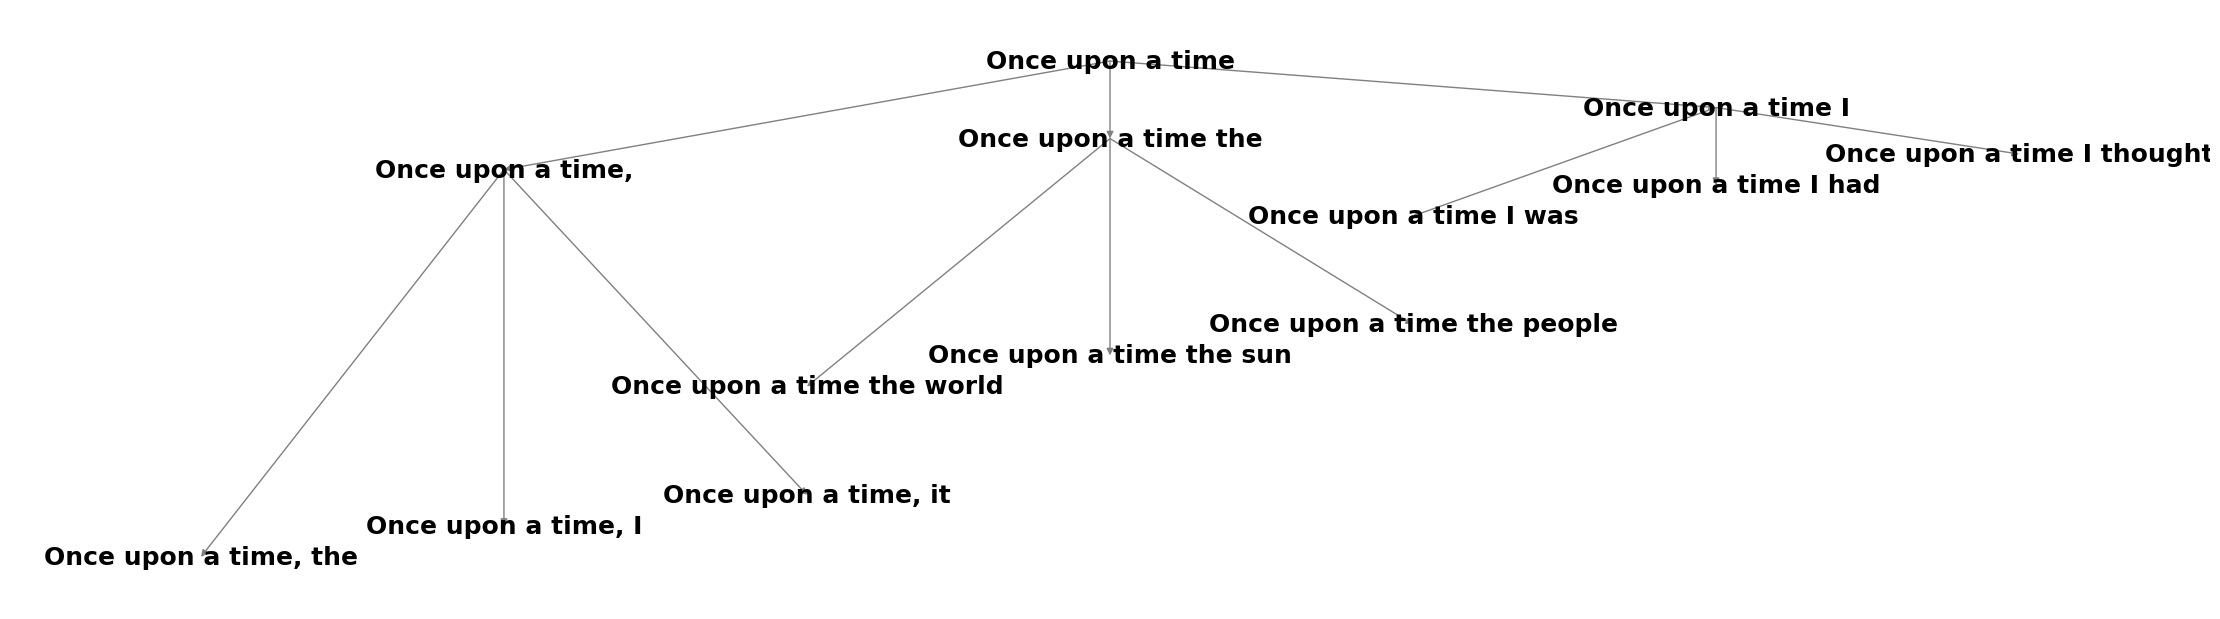

In [58]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import networkx as nx
import matplotlib.pyplot as plt

# Load pre-trained model and tokenizer from Hugging Face
model_name = "openai-community/gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()

# Function to perform beam search and track paths
def beam_search(input_text, beam_width=3, max_length=50):
    input_ids = tokenizer.encode(input_text, return_tensors='pt')
    sequences = [[list(input_ids[0]), 1.0]]
    finished_sequences = []

    # Initialize the graph
    G = nx.DiGraph()
    root = tuple(sequences[0][0])
    G.add_node(root, label=input_text)
    
    positions = {root: (0, 0)}
    y_step = 1  # Vertical distance between levels
    x_step = 1  # Horizontal distance between nodes at the same level

    for level in range(1, max_length + 1):
        all_candidates = []
        new_positions = {}

        for i, (seq, score) in enumerate(sequences):
            input_ids = torch.tensor([seq])
            with torch.no_grad():
                outputs = model(input_ids)
                next_token_logits = outputs.logits[0, -1, :]

            # Get top tokens and their scores
            next_token_scores = torch.topk(next_token_logits, beam_width)
            top_tokens = next_token_scores.indices
            top_scores = next_token_scores.values

            parent_pos = positions[tuple(seq)]

            for j, (token, token_score) in enumerate(zip(top_tokens, top_scores)):
                candidate = [seq + [token.item()], score * token_score.item()]
                all_candidates.append(candidate)
                candidate_tuple = tuple(candidate[0])
                G.add_node(candidate_tuple, label=tokenizer.decode(candidate[0], skip_special_tokens=True))
                G.add_edge(tuple(seq), candidate_tuple)
                
                # Calculate new position
                new_x = parent_pos[0] + (j - beam_width // 2) * (x_step/level)
                new_y = parent_pos[1] - level * y_step + (i+1)*y_step/2 + (j+1)*y_step/9
                new_positions[candidate_tuple] = (new_x, new_y)

        # Select the best candidates
        ordered = sorted(all_candidates, key=lambda x: x[1], reverse=True)
        sequences = ordered[:beam_width]

        # Stop if all sequences are finished
        if all(seq[-1] == tokenizer.eos_token_id for seq, _ in sequences):
            break

        # Update positions
        positions.update(new_positions)

    finished_sequences = [seq for seq, score in sequences]
    return finished_sequences, G, positions

# Example usage
input_text = "Once upon a time"
beam_width = 3
max_length = 2

finished_sequences, G, positions = beam_search(input_text, beam_width, max_length)

# Print finished sequences
for seq in finished_sequences:
    print(tokenizer.decode(seq, skip_special_tokens=True))

# Plot the search tree using specified positions
labels = nx.get_node_attributes(G, 'label')
plt.figure(figsize=(22, 6))
nx.draw(G, positions, with_labels=True, labels=labels, node_size=0, node_color="skyblue", font_size=18, font_weight="bold", arrows=True, edge_color="gray")
plt.show()


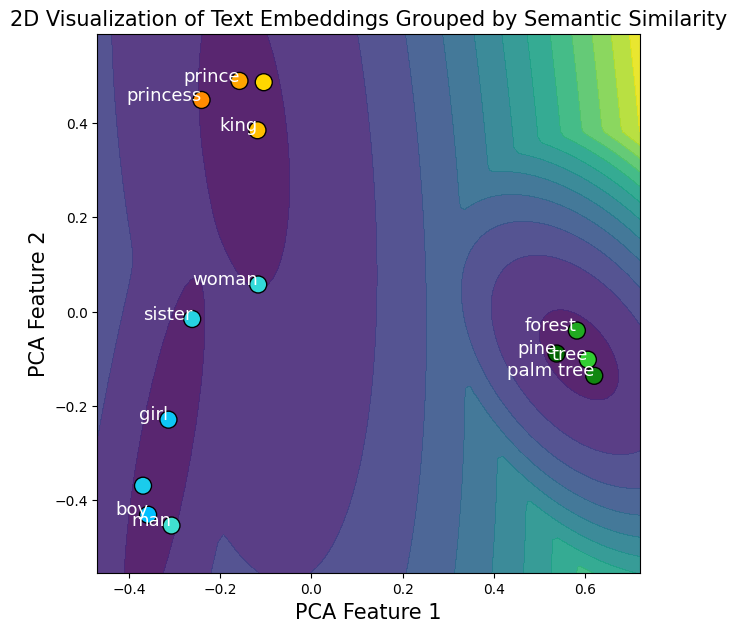

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sentence_transformers import SentenceTransformer

# List of texts to embed
# texts = ["man", "woman", "queen", "king", "tree", "forest", "palm tree", "pine", "sister", "brother", 
#          "prince", "princess", "girl", "boy", "birch", "redwood", "emperor", "empress", "father", "mother", 
#          "oak", "willow"]


# List of texts to embed
texts = ["man", "woman", "queen", "king", "tree", "forest", "palm tree", "pine", "sister", "brother", 
         "prince", "princess", "girl", "boy", ]
# Creating synthetic embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts)

# Using PCA for dimensionality reduction
pca = PCA(n_components=2)
embeddings_2d_pca = pca.fit_transform(embeddings)

# Clustering the embeddings into 3 groups using K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(embeddings_2d_pca)

# Fit a Gaussian Mixture Model for contour plotting
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(embeddings_2d_pca)

# Generating mesh grid for contour plots
x = np.linspace(np.min(embeddings_2d_pca[:, 0])-0.1, np.max(embeddings_2d_pca[:, 0]+0.1), 100)
y = np.linspace(np.min(embeddings_2d_pca[:, 1])-0.1, np.max(embeddings_2d_pca[:, 1])+0.1, 100)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm.score_samples(XX)
Z = Z.reshape(X.shape)

# Group texts by semantic similarity
groups = {
    'royalty': ["queen", "king", "prince", "princess", ],
    'gender': ["man", "woman", "sister", "brother", "girl", "boy",],
    'trees': ["tree", "forest", "palm tree", "pine",]
}

# Create a gradient color palette for each group
color_maps = {
    'royalty': LinearSegmentedColormap.from_list('royalty', ['gold', 'darkorange']),
    'gender': LinearSegmentedColormap.from_list('gender', ['turquoise', 'deepskyblue']),
    'trees': LinearSegmentedColormap.from_list('trees', ['limegreen', 'darkgreen'])
}

# Prepare colors for each point using a gradient within each group
num_items = {group: len(members) for group, members in groups.items()}
point_colors = []
for text in texts:
    for group, members in groups.items():
        if text in members:
            index = members.index(text)
            color_map = color_maps[group]
            color = color_map(index / (num_items[group] - 1))
            point_colors.append(color)

# Plotting
plt.figure(figsize=(7, 7))
plt.contourf(X, Y, Z, levels=14, cmap='viridis', alpha=0.9)  # Using a viridis colormap for contour
scatter = sns.scatterplot(x=embeddings_2d_pca[:, 0], y=embeddings_2d_pca[:, 1], s=150, hue=point_colors, palette=point_colors, legend=None,edgecolor='black')
# scatter.set_xlim(-0.5, 0.5)
# Annotating the plot
for i, text in enumerate(texts):
    if text == 'queen' or text =='brother':
        continue
    # if i % 2 == 0:
    plt.text(embeddings_2d_pca[i, 0], embeddings_2d_pca[i, 1], text, fontsize=13, ha='right', color='white')

# Title and labels
plt.title("2D Visualization of Text Embeddings Grouped by Semantic Similarity", fontsize=15)
plt.xlabel("PCA Feature 1", fontsize=15)
plt.ylabel("PCA Feature 2", fontsize=15)

# Display the plot
plt.show()


In [6]:
import pandas as pd

# Creating 10 bad reviews
bad_reviews = [
    "Absolutely terrible. The plot was predictable and the acting was wooden.",
    "Waste of time. The special effects were laughable and the story made no sense.",
    "Very disappointing. The characters were one-dimensional and not at all likable.",
    "A total letdown. The pacing was slow and it failed to hold my attention.",
    "Not recommended. The script was full of cliches and lacked originality.",
    "Boring and uneventful. The movie dragged on with no real purpose.",
    "Poorly made. The editing was choppy and the sound quality was bad.",
    "Not worth watching. The dialogue was cheesy and the humor fell flat.",
    "A big disappointment. The film lacked depth and the ending was unsatisfying.",
    "Terrible execution. The direction was poor and the cinematography was unimpressive.",
    "Dull and uninspiring. The storyline was unoriginal and the ending was predictable.",
    "Failed to impress. The performances were mediocre and the direction lacked vision.",
    "Forgettable and tedious. The film had no real suspense or engaging elements.",
    "A real snooze-fest. The script was uninspired and the characters were forgettable.",
    "Missed the mark. The film tried too hard to be deep but ended up being pretentious.",
    "Lackluster and unconvincing. The plot twists were predictable and uninteresting.",
    "Unappealing and draggy. The movie seemed to go on forever without any real point.",
    "Disjointed and confusing. The narrative was hard to follow and lacked coherence.",
    "Underwhelming in every aspect. The cinematography was bland and the soundtrack forgettable.",
    "A waste of potential. The movie had a good premise but failed in execution.",
]

# Creating 10 good reviews
good_reviews = [
    "Absolutely fantastic. The plot was original and the acting was superb.",
    "A must-see. The special effects were stunning and the story was captivating.",
    "Highly recommended. The characters were complex and very relatable.",
    "A masterpiece. The pacing was perfect and it kept me engaged throughout.",
    "Brilliantly written. The script was fresh and full of creativity.",
    "Engaging and entertaining. The movie flowed smoothly and had a strong message.",
    "Well-crafted. The editing was seamless and the sound quality was top-notch.",
    "Thoroughly enjoyable. The dialogue was witty and the humor was spot on.",
    "A true gem. The film had depth and the ending was very satisfying.",
    "Outstanding direction. The cinematography was stunning and visually impressive.",
    "Riveting and captivating. The story was engaging with plenty of unexpected twists.",
    "A visual masterpiece. The cinematography and special effects were breathtaking.",
    "Brilliantly acted. The cast delivered powerful and memorable performances.",
    "A refreshing take on the genre. The film brought new ideas and executed them perfectly.",
    "Heartfelt and moving. The story resonated emotionally and stayed with me long after.",
    "Excellently paced. The film kept the excitement up from start to finish.",
    "A work of art. The direction was innovative and the script was clever and insightful.",
    "Engrossing and thought-provoking. The film challenges the audience in the best way.",
    "A triumph of storytelling. The narrative was intricate yet perfectly balanced.",
    "A delightful surprise. The movie exceeded expectations with its charm and wit.",
]

# Combining reviews with labels
reviews = bad_reviews + good_reviews
labels = ['Bad'] * 20 + ['Good'] * 20

# Creating a DataFrame
df = pd.DataFrame({'Review': reviews, 'Label': labels})
df.head(20)


,Review,Label
0,Absolutely terrible. The plot was predictable ...,Bad
1,Waste of time. The special effects were laugha...,Bad
2,Very disappointing. The characters were one-di...,Bad
3,A total letdown. The pacing was slow and it fa...,Bad
4,Not recommended. The script was full of cliche...,Bad
5,Boring and uneventful. The movie dragged on wi...,Bad
6,Poorly made. The editing was choppy and the so...,Bad
7,Not worth watching. The dialogue was cheesy an...,Bad
8,A big disappointment. The film lacked depth an...,Bad
9,Terrible execution. The direction was poor and...,Bad


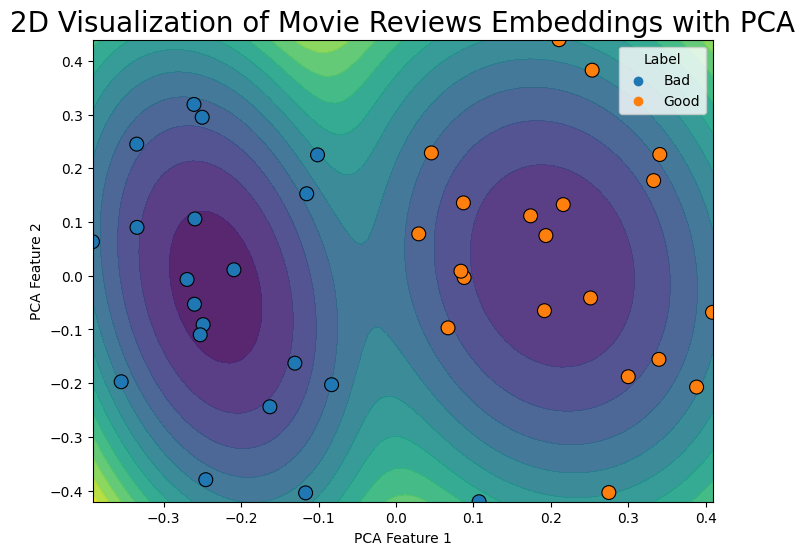

In [7]:
embeddings = model.encode(df['Review'].tolist())

# Using PCA for dimensionality reduction
pca = PCA(n_components=2)
embeddings_2d_pca = pca.fit_transform(embeddings)

# Fit a Gaussian Mixture Model for two clusters
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(embeddings_2d_pca)

# Generate mesh grid for the contour plots
x = np.linspace(np.min(embeddings_2d_pca[:, 0]), np.max(embeddings_2d_pca[:, 0]), 100)
y = np.linspace(np.min(embeddings_2d_pca[:, 1]), np.max(embeddings_2d_pca[:, 1]), 100)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -gmm.score_samples(XX)
Z = Z.reshape(X.shape)

# Create a scatter plot with color coding
plt.figure(figsize=(8, 6))
colors = ['green' if label == 'Good' else 'red' for label in df['Label']]
plt.contourf(X, Y, Z, levels=14, cmap='viridis', alpha=0.9)  # Using a viridis colormap for contour

sns.scatterplot(x=embeddings_2d_pca[:, 0], y=embeddings_2d_pca[:, 1], hue=df['Label'], s=100,edgecolor='black')

# Optionally add texts if needed (commented out by default)
# for i, text in enumerate(df['Review']):
#     plt.text(embeddings_2d_pca[i, 0], embeddings_2d_pca[i, 1], text, fontsize=9, ha='right', color='black',
#              bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='none', alpha=0.5))

# Add contours to the plot

# Styling the plot
plt.title("2D Visualization of Movie Reviews Embeddings with PCA", fontsize=20)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.show()

C:\Users\takat\AppData\Local\Temp\ipykernel_14252\1030301358.py:37: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=embeddings_2d_pca[:, 0], y=embeddings_2d_pca[:, 1], palette="deep")


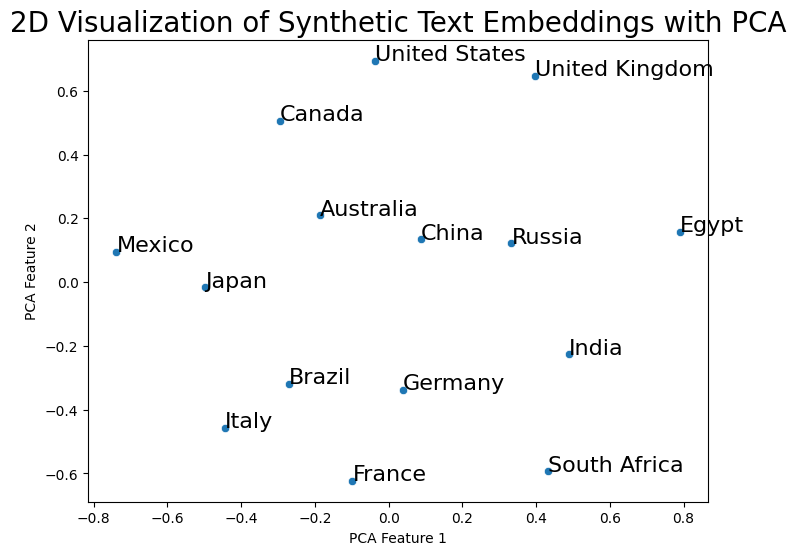

In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA


# List of texts to embed
# Redefining the list of texts
texts = [
    "United States", "Canada", "Mexico", "Brazil", "United Kingdom",
    "Germany", "France", "Italy", "Russia", "China", "Japan", "India",
    "Australia", "South Africa", "Egypt",
]

# Creating synthetic embeddings
# np.random.seed(42)  # Fixing the random seed for reproducibility
# embeddings = np.random.rand(len(texts), 10)  # 10-dimensional embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

# Embedding the texts
embeddings = model.encode(texts)

from sklearn.manifold import MDS

# Create an MDS instance specifying the number of dimensions (n_components=2 for 2D)
mds = MDS(n_components=2)

# Apply MDS to the embeddings
embeddings_2d_pca = mds.fit_transform(embeddings)

# embeddings_2d_mds now contains the 2-dimensional representation of your embeddings

# Visualizing the embeddings using the viridis color scheme
plt.figure(figsize=(8, 6))
sns.scatterplot(x=embeddings_2d_pca[:, 0], y=embeddings_2d_pca[:, 1], palette="deep")
for i, text in enumerate(texts):
    plt.text(embeddings_2d_pca[i, 0], embeddings_2d_pca[i, 1], text, fontsize=16)
plt.title("2D Visualization of Synthetic Text Embeddings with PCA", fontsize=20)
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
# sns.set(style="whitegrid")
plt.show()

In [6]:
# Re-defining the texts and lat_lng_data as they were not recognized in the previous code cell

texts = [
    "United States", "Brazil", "United Kingdom",
    "Germany", "Italy",  "China", "Japan", 
    "Australia", "South Africa", "Egypt",
]
# Defining neighbors for each country
neighbors = {
    "United States": "Canada",
    "Brazil": "Argentina",
    "United Kingdom": "Ireland",
    "Germany": "France",
    "Italy": "Switzerland",
    "China": "India",
    "Japan": "South Korea",
    "Australia": "New Zealand",
    "South Africa": "Zimbabwe",
    "Egypt": "Libya"
}

# Creating a new list with one neighbor for each country
one_neighbor_list = [neighbors[country] for country in texts]
one_neighbor_list



['Canada',
 'Argentina',
 'Ireland',
 'France',
 'Switzerland',
 'India',
 'South Korea',
 'New Zealand',
 'Zimbabwe',
 'Libya']

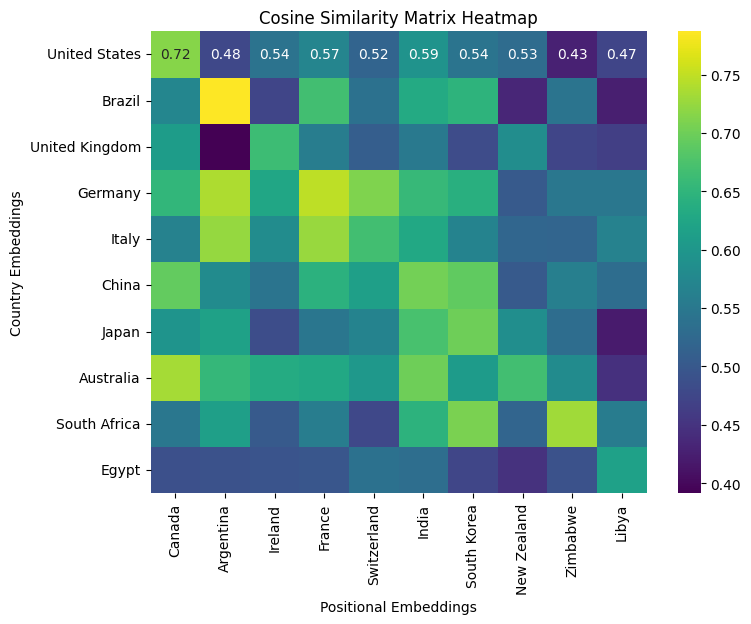

In [7]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
embeddings_countries = model.encode(texts)
embeddings_pos = model.encode(one_neighbor_list)
cosine_sim_matrix = cosine_similarity(embeddings_countries, embeddings_pos)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cosine_sim_matrix, annot=True, cmap='viridis', 
            xticklabels=one_neighbor_list, yticklabels=texts)
plt.title("Cosine Similarity Matrix Heatmap")
plt.xlabel("Positional Embeddings")
plt.ylabel("Country Embeddings")
plt.show()

c:\Users\takat\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


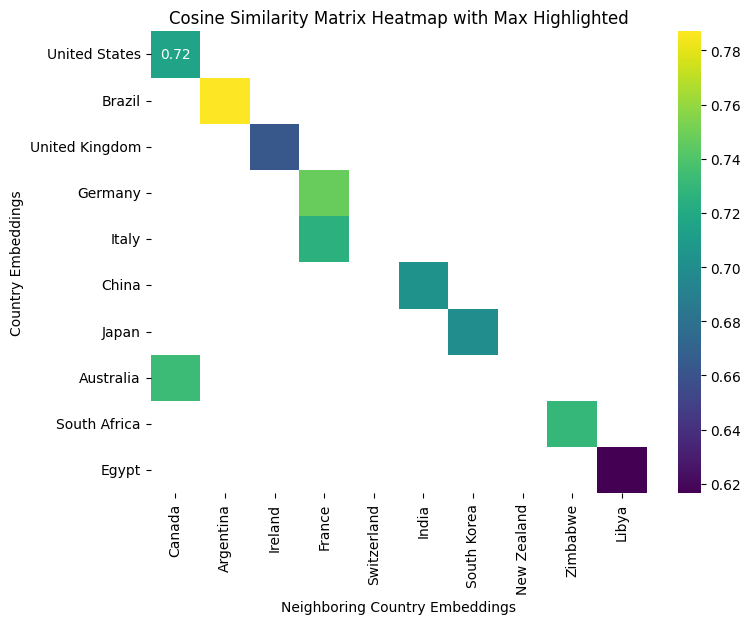

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Create a mask for the maximum value in each row
max_mask = np.zeros_like(cosine_sim_matrix, dtype=bool)
for i in range(len(cosine_sim_matrix)):
    max_mask[i, np.argmax(cosine_sim_matrix[i])] = True

# Plotting the heatmap with proper labels and the maximum values highlighted
plt.figure(figsize=(8, 6))
sns.heatmap(cosine_sim_matrix, mask=~max_mask, annot=True, cmap='viridis', 
            xticklabels=one_neighbor_list, yticklabels=texts)
plt.title("Cosine Similarity Matrix Heatmap with Max Highlighted")
plt.xlabel("Neighboring Country Embeddings")
plt.ylabel("Country Embeddings")
plt.show()